# Setup

In [1]:
import os
import glob
import cv2
from matplotlib import pyplot as plt

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

# Image printing/saving helper

In [2]:
def print_save_imgs(imgs, titles, eval):
    '''Organizes images into a grid and saves to figures folder'''

    fig, axs = plt.subplots(len(imgs), 1, figsize=(5, 10))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')

    fig.savefig(f'../figures/{eval}.png', bbox_inches='tight')

# Evaluation Functions

In [3]:
def eval_baseline(glob_path):
    '''
    Runs baseline decoder and counts the number of decodings
    '''
    img_paths = glob.glob(glob_path)

    # stat tracking
    num_decodings = 0
    num_valid_decodings = 0

    imgs = []
    titles = []

    for img_path in img_paths:
        img = cv2.imread(img_path)

        decodings = decode(img)

        actual_decoding = os.path.basename(img_path).split('_')[0]
        actual_decoding = actual_decoding.replace('-', '')

        # fixing some actual decodings
        if actual_decoding == 'KV8INMEP':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
        elif actual_decoding == 'KW8PXY3D':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

        if decodings is not None and len(decodings) > 0:
            num_decodings += 1

            for decoding in decodings:
                decoded_string = decoding.data.decode('utf-8')

                if decoded_string == actual_decoding:
                    print(f'Valid decoding! {actual_decoding}')
                    num_valid_decodings += 1
                    imgs.append(img)
                    titles.append(actual_decoding)
                else:
                    print('Invalid decoding!')
                    print(actual_decoding)
                    print(decoded_string)

    # calculate stats
    dm_decode_rate = num_decodings/len(img_paths)
    valid_decode_rate = num_valid_decodings/len(img_paths)

    print()
    print(f'{num_valid_decodings}/{len(img_paths)}')
    print(f'Dm decode rate: {dm_decode_rate}')
    print(f'Valid decode rate: {valid_decode_rate}')
    print_save_imgs(imgs, titles, 'baseline')

In [4]:
def eval_map(model, eval_yaml):
    '''
    Runs ultralytics val function to get mAP score and other metrics
    '''
    metrics = model.val(data=eval_yaml, split='test')

    print()
    print(f'Precision : {round(metrics.box.p[0], 2)}')  # close to 1 is good
    print(f'Recall    : {round(metrics.box.r[0], 2)}')  # close to 1 is good
    print(f'F1        : {round(metrics.box.f1[0], 2)}') # close to 1 is good
    print(f'mAP50-95  : {round(metrics.box.map, 3)}')   # 0.3 can be good, higher is better

In [5]:
def crop_decoding(model, glob_path, fig_title):
    '''
    Performs cropping and decoding of the images
    '''
    img_paths = glob.glob(glob_path)

    # stat tracking
    num_decodings = 0
    num_valid_decodings = 0

    imgs = []
    titles = []

    idx = 0
    for img_path in img_paths:
        img = cv2.imread(img_path)
        results = model(img)
        boxes = results[0].boxes.xyxy.tolist()

        actual_decoding = os.path.basename(img_path).split('_')[0]
        actual_decoding = actual_decoding.replace('-', '') # minor cleaning

        # fixing some actual decodings
        if actual_decoding == 'KV8INMEP':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
        elif actual_decoding == 'KW8PXY3D':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

        if boxes != None:
            for box in boxes:
                # crop with some padding (to not have too small of a crop)
                pad = 10
                # crop_obj = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])] # no padding
                crop_obj = img[max(0, int(box[1])-pad):max(0, int(box[3])+pad), max(0, int(box[0])-pad):max(0, int(box[2])+pad)]
                decodings = decode(crop_obj)

                if decodings != None and len(decodings) > 0:
                    num_decodings += 1

                    for decoding in decodings:
                        decoded_string = decoding.data.decode('utf-8')
                        
                        if decoded_string == actual_decoding:
                            print(f'Valid decoding! {actual_decoding}')
                            num_valid_decodings += 1
                            imgs.append(crop_obj)
                            titles.append(actual_decoding)
                        else:
                            print('Invalid decoding!')
                            print(actual_decoding)
                            print(decoded_string)

                # optional saving
                cv2.imwrite(f'../data/cropped/{actual_decoding}-{idx}.jpg', crop_obj)
                idx += 1

    # calculate stats
    dm_decode_rate = num_decodings/len(img_paths)
    valid_decode_rate = num_valid_decodings/len(img_paths)

    print()
    print(f'{num_valid_decodings}/{len(img_paths)}')
    print(f'Dm decode rate: {dm_decode_rate}')
    print(f'Valid decode rate: {valid_decode_rate}')
    print_save_imgs(imgs, titles, fig_title)

In [6]:
def eval_yolo(model_path, glob_path, eval_yaml, fig_title):
    '''
    Given a yolo model, makes the following evaluations:
     - mAP scores for bounding boxes
     - DM decode rate (% of decodings of test images)
     - Valid DM decode rate (% of decodings of test images that match with the serial number)
    Also prints the first "print_count" images with predictions.
    '''
    # Load the model
    model = YOLO(model_path)

    # mAP scores (saves to runs dir)
    eval_map(model, eval_yaml)

    # Crop and decode
    crop_decoding(model, glob_path, fig_title)

# Baseline

Valid decoding! 250115190210016
Valid decoding! 4F1K99136940006
Valid decoding! 4F1K99136940007
Valid decoding! 9G7Q08437560006
Valid decoding! #D1FPE50HA9NS0047XG264##KV8INMEP
Valid decoding! #D1FPE50HA9NS0047XG264##KW8PXY3D

6/50
Dm decode rate: 0.12
Valid decode rate: 0.12


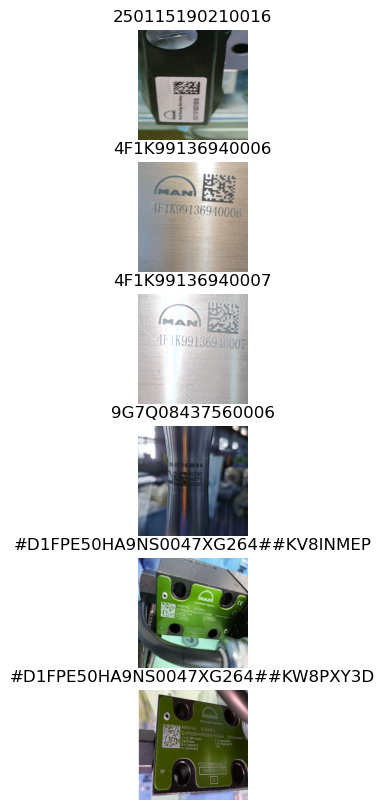

In [7]:
eval_baseline('../data/MAN/images/test/*.jpg')

## Kaggle from Scratch

Ultralytics 8.3.3  Python-3.12.6 torch-2.4.1 CPU (Intel Core(TM) i7-1065G7 1.30GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients


val: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\data\MAN\labels\test.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


                   all         50         50      0.254       0.24      0.107     0.0694
Speed: 3.2ms preprocess, 142.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\yolo\runs\detect\val

Precision : 0.25
Recall    : 0.24
F1        : 0.25
mAP50-95  : 0.069

0: 640x640 6 Data Matrixs, 485.6ms
Speed: 6.0ms preprocess, 485.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 100.0ms
Speed: 4.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 98.0ms
Speed: 4.0ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 124.0ms
Speed: 5.0ms preprocess, 124.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Valid decoding! 250115190210016

0: 640x640 (no detections), 159.0ms
Speed: 5.0ms

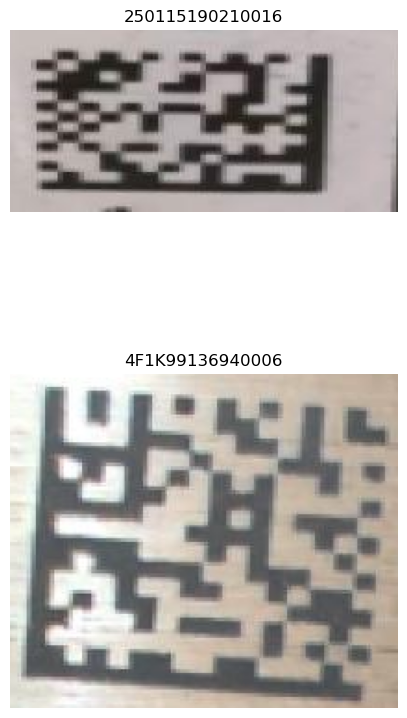

In [8]:
eval_yolo('../yolo/models/kaggle_scratch.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Kaggle Scratch')

## Kaggle finetuned

Ultralytics 8.3.3  Python-3.12.6 torch-2.4.1 CPU (Intel Core(TM) i7-1065G7 1.30GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients


val: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\data\MAN\labels\test.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


                   all         50         50      0.913      0.837      0.912      0.746
Speed: 3.1ms preprocess, 123.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\yolo\runs\detect\val2

Precision : 0.91
Recall    : 0.84
F1        : 0.87
mAP50-95  : 0.746

0: 640x640 1 Data Matrix, 211.0ms
Speed: 4.0ms preprocess, 211.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 278.0ms
Speed: 3.0ms preprocess, 278.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 198.0ms
Speed: 4.0ms preprocess, 198.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 141.0ms
Speed: 3.0ms preprocess, 141.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Valid decoding! 250115190210016

0: 640x640 1 Data Matrix, 149.0ms
Speed: 8.0ms p

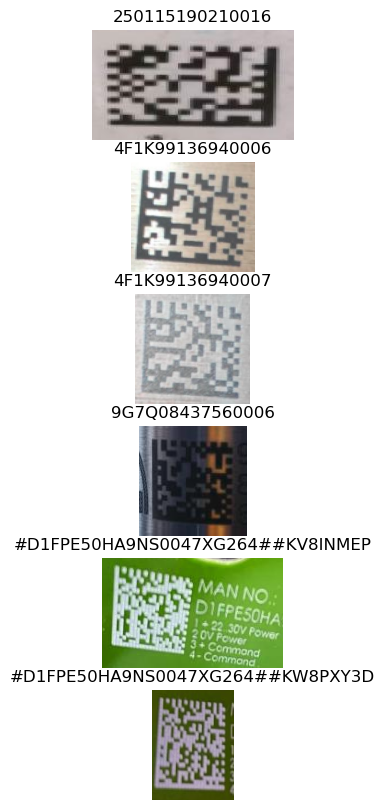

In [9]:
eval_yolo('../yolo/models/kaggle_finetuned.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Kaggle Finetuned')

## Ultralytics finetuned

Ultralytics 8.3.3  Python-3.12.6 torch-2.4.1 CPU (Intel Core(TM) i7-1065G7 1.30GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients


val: Scanning C:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\data\MAN\labels\test.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


                   all         50         50      0.957      0.895      0.947      0.753
Speed: 2.8ms preprocess, 136.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to c:\Users\aidan\OneDrive\Desktop\itu\msc\courses\sem3\research_project\Research-Project-Data-Matrix-Code-\yolo\runs\detect\val3

Precision : 0.96
Recall    : 0.89
F1        : 0.92
mAP50-95  : 0.753

0: 640x640 1 Data Matrix, 123.0ms
Speed: 4.0ms preprocess, 123.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 165.5ms
Speed: 4.5ms preprocess, 165.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 124.0ms
Speed: 4.0ms preprocess, 124.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Data Matrix, 107.0ms
Speed: 5.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Valid decoding! 250115190210016

0: 640x640 1 Data Matrix, 111.0ms
Speed: 3.0ms p

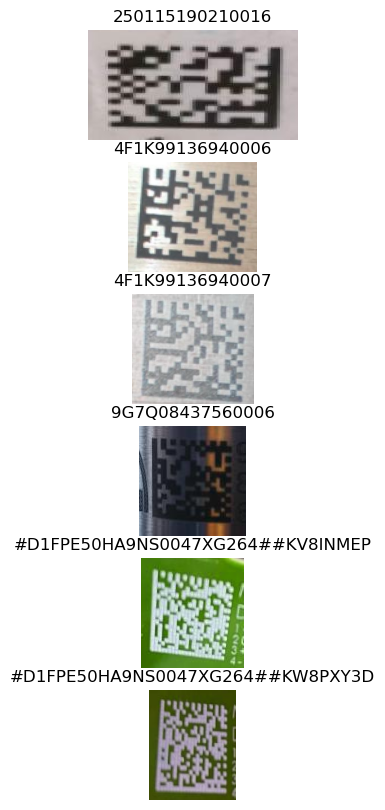

In [10]:
eval_yolo('../yolo/models/ultralytics_finetuned.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Ultralytics Finetuned')